# Learning Curves

### Preamble

In [1]:
SYS_PATH = r'C:/Users/mark/Documents/GitHub/honours/dev/package/'
SAVE_PATH = r"C:/Users/mark/Documents/GitHub/honours/submissions/thesis-original"
LOAD_PATH = r"C:/Users/mark/Documents/GitHub/honours/dev/package/analysis/output/temp/output.db"

In [2]:
#standard imports
import sys
import numpy as np
import scipy.stats as stats
import pandas as pd
from datetime import date, timedelta
import math
from itertools import chain

#third party imports
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as tkr
import seaborn as sns
from sklearn import metrics

In [3]:
import importlib
import sys; sys.path.append(SYS_PATH)
import analysis.helper as helper
importlib.reload(helper)
%matplotlib inline

In [4]:
plt.style.use(['seaborn-white', 'seaborn-paper'])

In [5]:
palette = ["#244397", "#3754A0", "#5F76B3", "#D3D3D3", "#E8CC77", "#DCAF2A", "#9a7a1d"] * 2#"colorblind"
TINY_SIZE, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE  = 16, 24, 30, 36
rcParams['font.family'] = 'serif' 
rcParams['font.serif'] = 'CMU Serif' 
rcParams['font.weight'] = 'bold'
rcParams['figure.figsize'] = (12, 6) #(8,3)
pd.set_option('precision',3)

In [6]:
sns.set_palette(palette)
rcParams['font.size'] = SMALL_SIZE #default font size
rcParams['axes.titlesize'] =SMALL_SIZE   # fontsize of the axes title
rcParams['axes.labelsize'] =MEDIUM_SIZE    # fontsize of the x and y labels
rcParams['xtick.labelsize'] =SMALL_SIZE    # fontsize of the tick labels
rcParams['ytick.labelsize'] =SMALL_SIZE   # fontsize of the tick labels
rcParams['legend.fontsize'] =SMALL_SIZE    # legend fontsize
rcParams['figure.titlesize'] =BIGGER_SIZE  # fontsize of the figure title
outline_bars = dict(linewidth = 1.25, edgecolor = '.15')

In [7]:
def plot_learning_curve(df, ax = None, group = None, target = None, multiple=False, legend=False):
    
    def concat_lists(series):
        return np.array(list(zip(*[element for list_ in [np.array(list(zip(*list_))) for list_ in series] for element in list_])))

    if not ax: ax = plt.gca()
    
    if group and target:
        test_scores = concat_lists(df.loc[df[group] == target]["Test_Scores"])
        train_scores = concat_lists(df.loc[df[group] == target]["Train_Scores"])
        train_sizes = df.loc[df[group] == target]["Train_Sizes"].sample(1).squeeze()
        ax.set_title("{}".format(target))
    else:
        test_scores = concat_lists(df["Test_Scores"])
        train_scores = concat_lists(df["Train_Scores"])
        train_sizes = df["Train_Sizes"].sample(1).squeeze()

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores,axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
            
    ax.plot(train_sizes, train_mean, 'o-', color="blue", label="Training")
    ax.plot(train_sizes, test_mean, 'o-', color="green", label="Cross-validation")
    
    handles, labels = ax.get_legend_handles_labels()

    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
    ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")
    
    ax.set_ylim(ymin=0, ymax=1)
    ax.set_xticklabels(["{:,.0f}".format(xtick) for xtick in ax.get_xticks().tolist()])

    return (handles, labels)

In [8]:
def plot_learning_curves(df, group, x_label='Training Examples',y_label ='Score',figsize=None):
    targets = df[group].value_counts().index.tolist()
    if len(targets) == 3: rows, cols = 1, 3
    elif len(targets) == 7: rows, cols = 2, 4
    else:
        cols = math.ceil(math.sqrt(len(targets)))
        rows = math.ceil(len(targets) / cols)
    f, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize, sharey=True)
    axes = [item for sublist in axes for item in sublist]
    if len(targets) == 1: axes = [axes]
    for i, target in enumerate(targets):
        leg = plot_learning_curve(df, axes[i], group=group, target=target, multiple=True)
        #if i == 6: axes[i].legend(*leg)
    for x in range(len(targets), len(axes)): f.delaxes(axes[x])
    plt.figlegend(*leg, bbox_to_anchor=(1.02, 0.3), loc="center right")
    f.text(0.5, -0.04, x_label, ha='center',size=MEDIUM_SIZE)
    f.text(-0.04, 0.5, y_label, va='center', rotation='vertical',size=MEDIUM_SIZE)
    plt.tight_layout()
    return f

### Learning curves by forecast window (DONE)

In [104]:
reload = True

In [128]:
chart_id = "figures/evaluation/learning_curves_window"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [106]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = helper.get_results(26, "evaluate") #25
    data = data[["dataset_size", "PRC", "dataset_type","forecast_window_years"]]
    data.to_pickle(pickle_path)

In [107]:
x = "dataset_size"
y = "PRC"
hue = "dataset_type"
hue_order = ["Training Score", "Test Score"]
col = "forecast_window_years"
col_order = ["2 Years", "3 Years", "4 Years"]

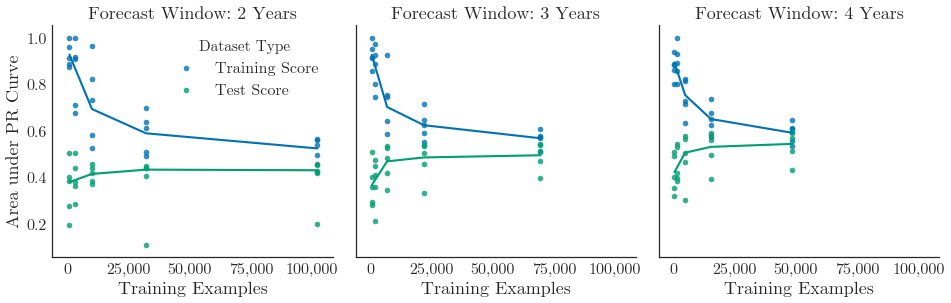

In [127]:
f = sns.lmplot(data = data, x=x, y=y, hue=hue, col=col, hue_order=hue_order,fit_reg =True, lowess  =True, legend=True, legend_out=False, size=4.5)
f = f.set_axis_labels("Training Examples", "Area under PR Curve")
f = f.set_titles("Forecast Window: {col_name}")
helper.format_axis_ticks(f, axis="x", fmt="{:,}")
plt.tight_layout()
f = f.add_legend(title="Dataset Type")

In [129]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Learning curves by target outcome (DONE)

In [163]:
reload = False

In [164]:
chart_id = "figures/evaluation/learning_curves_outcome"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [165]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = helper.get_results(36, "evaluate") #16
    data = data[["dataset_size", "PRC", "dataset_type","label_type","forecast_window_years"]]
    #data = data.loc[data["forecast_window_years"] == "4 Years"]
    data.to_pickle(pickle_path)

Error: Time
Error: Imputer
Error: Transformer
Error: Scaler
Error: Extractor


In [166]:
x = "dataset_size"
y = "PRC"
hue = "dataset_type"
col = "label_type"
row= "forecast_window_years"

In [167]:
hue_order = ["Training Score", "Test Score"]
col_order = ["Extra Stage", "Extra Round", "Exit", "Acquisition", "IPO"]
x_label = "Training Examples"
y_label = "Area under PR Curve"
f_titles = "Outcome: {col_name}"
leg_title = "Dataset Type"

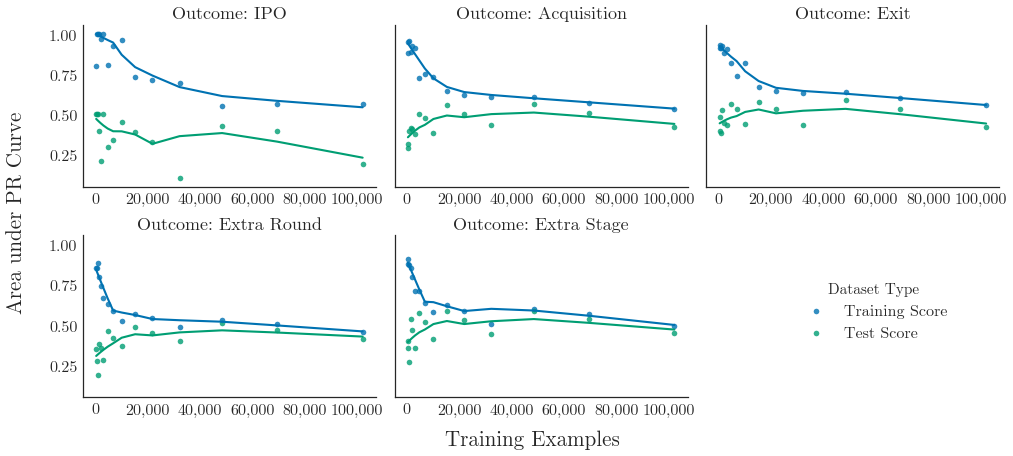

In [168]:
f = sns.lmplot(data = data, x=x, y=y, hue=hue, col=col, col_wrap=3, hue_order=hue_order, fit_reg =True, lowess  =True, legend=False, legend_out=False, sharex=False, size=3, aspect=1.5)
f = f.set_axis_labels("", "")
f = f.set_titles(f_titles)
helper.format_axis_ticks(f, axis="x", fmt="{:,}")
plt.tight_layout()
f.fig.text(0.5, -0.04, x_label, ha='center',size=MEDIUM_SIZE+3)
f.fig.text(-0.04, 0.5, y_label, va='center', rotation='vertical',size=MEDIUM_SIZE+3)
f = f.add_legend(title=leg_title, bbox_to_anchor = (3, -0.5))

In [169]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Learning curves by developmental stage

In [9]:
reload = True

In [10]:
chart_id = "figures/evaluation/learning_curves_stage"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [11]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = helper.get_results(37, "evaluate") #16
    data = data[["dataset_size", "PRC", "dataset_type","feature_stage_single","forecast_window_years"]]
    #data = data.loc[data["forecast_window_years"] == "4 Years"]
    data.to_pickle(pickle_path)

In [12]:
x = "dataset_size"
y = "PRC"
hue = "dataset_type"
col = "feature_stage_single"

In [20]:
import itertools

In [23]:
hue_order = ["Training Score", "Test Score"]
col_order = reversed(["Pre-Seed", "Seed", "Series A", "Series B", "Series C", "Series D+"])
x_label = "Training Examples"
y_label = "Area under Precision-Recall Curve"
f_titles = "Stage: {col_name}"
leg_title = "Dataset Type"

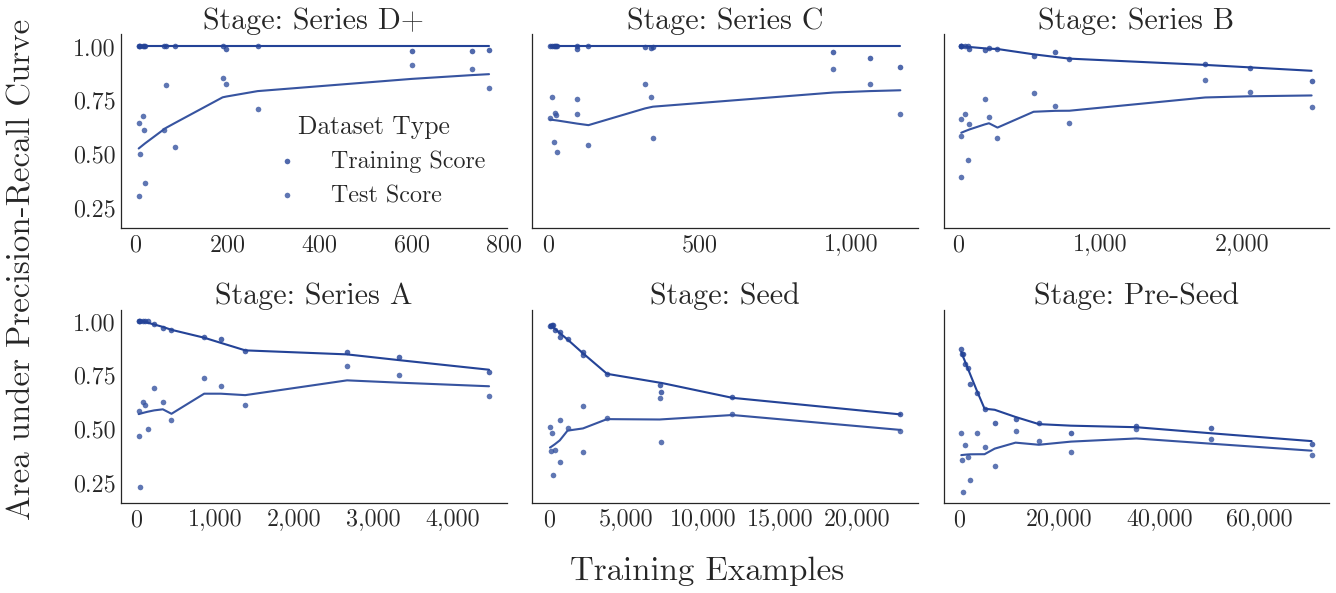

In [24]:
f = sns.lmplot(data = data, x=x, y=y, hue=hue, col=col, col_wrap=3, hue_order=hue_order, fit_reg =True, lowess  =True, legend=True, legend_out=False, sharex=False, size=4, aspect=1.5)
f = f.set_axis_labels("", "")
f = f.set_titles(f_titles)
helper.format_axis_ticks(f, axis="x", fmt="{:,}")
plt.tight_layout()
f.fig.text(0.5, -0.04, x_label, ha='center',size=MEDIUM_SIZE+3)
f.fig.text(-0.04, 0.5, y_label, va='center', rotation='vertical',size=MEDIUM_SIZE+3)
f = f.add_legend(title=leg_title)

In [195]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Learning curves by classification algorithms (DONE)

In [196]:
reload = True

In [197]:
chart_id = "figures/design/learning_curves_classifier"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [198]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = helper.get_results(16, "create")
    data = data[["Classifier","Test_Scores","Train_Scores","Train_Sizes"]]
    data.to_pickle(pickle_path)

In [199]:
x_label = "Training Examples"
y_label = "Area under PR Curve"

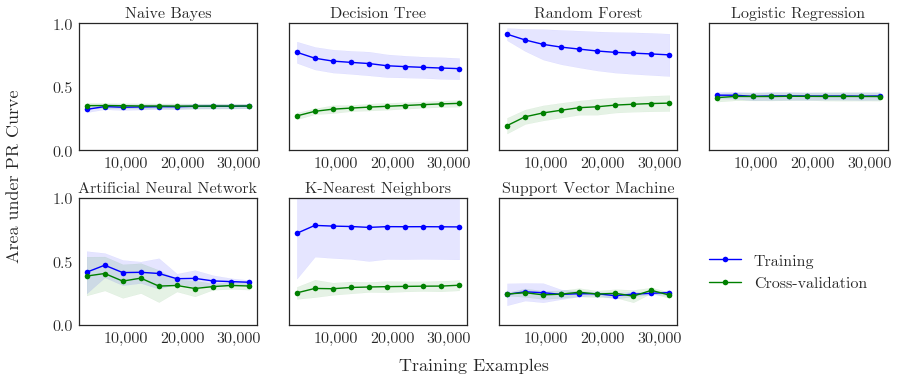

In [200]:
with plt.rc_context({'figure.figsize': (12,5)}):
    f = plot_learning_curves(data, group="Classifier", x_label=x_label, y_label=y_label)

In [201]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")